# FEM Modelling for Three-Phase STEDIN Transformer

### Voltage-fed Analysis - Non-Linear BH Curve

The nonlinear magnetic characteristic with hysteresis neglected can be approximated as given in [1].
\begin{equation}
    \frac{1}{\mu} = k_1 e^{k_2B^2} + k_3
\end{equation}
where, $k_1$, $k_2$ and $k_3$ are constants equal to 3.8, 2.17, and 396.2, respectively.

[1] J. Brauer, “Simple equations for the magnetization and reluctivity curves of steel,” IEEE Transactions on Magnetics, vol. 11, no. 1, pp. 81–81, 1975.

## Import Packages

In [1]:
print(" ▸ Loading Packages .... \r")
start = time_ns()
using gmsh
using LinearAlgebra
using LaTeXStrings
using Plots
using CSV
using DataFrames
include("../../../../lib/Makie_Plots.jl");
using .Makie_Plots
include("../../../../lib/FEM_VoltageFed_Tri_1e.jl");
using .FEM_VoltageFed_Tri_1e
include("../../../../lib/Post_Process_Frequency.jl");
using .Post_Process_Frequency
include("../../../../lib/Mesh_Data_stedin.jl");
using .Mesh_Data_stedin
include("../../../../lib/Save_VTK.jl");
using .Save_VTK
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Packages loaded ("*string(elapsed)*" seconds)                               ")

 ✓ Packages loaded (22.87 seconds)                               


## BH Curve

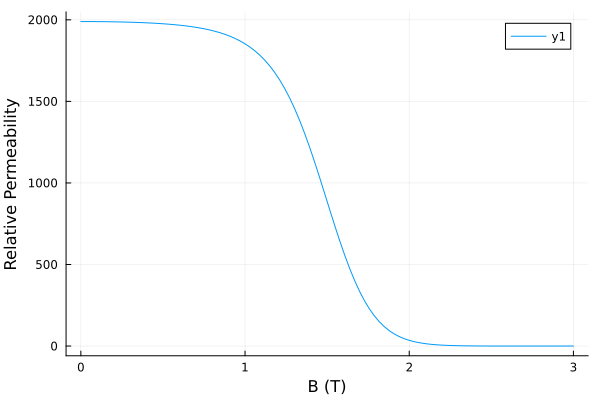

In [2]:
# Plot of mu vs B
mu0 = 4e-7 * pi;
function mu_func(B)
    k1 = 3.8;
    k2 = 2.17;
    k3 = 396.2;
    mu0 = 4e-7 * pi;
    v = k1 * exp(k2*B^2) + k3;
    return (1 ./ v)
end

B = collect(range(0, 3.0, 100))
plot(B,mu_func.(B)/mu0)
xlabel!("B (T)")
ylabel!("Relative Permeability")

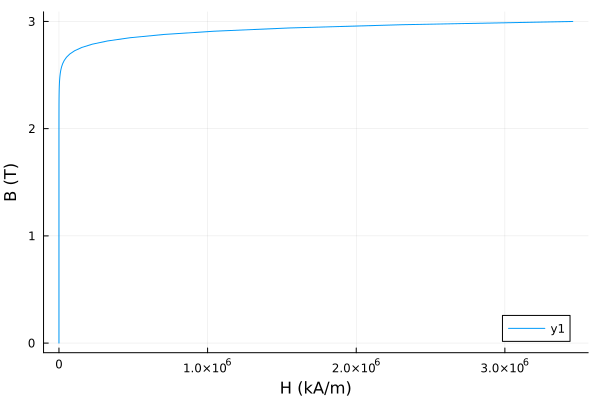

In [3]:
plot(B./mu_func.(B)/1000,B)
xlabel!("H (kA/m)")
ylabel!("B (T)")

## Julia code

In [4]:
gmsh.initialize()

## Read mesh from file
print(" ▸ Reading mesh file .... \r")
start = time_ns()
gmsh.open("../../../../Geometry/mesh/stedin_transformer.msh")
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Mesh file loaded ("*string(elapsed)*" seconds)                               ")

print(" ▸ Generating required mesh data .... \r")
start = time_ns()
mesh_data = get_mesh_data_tri_1e(gmsh)
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Mesh data generated ("*string(elapsed)*" seconds)                               ")

print(" ▸ Setting initial parameters .... \r")
start = time_ns()
S = 400e3;                    # Power rating
Vp = 10750 * sqrt(2);         # Primary peak phase voltage
Vs = 420 * sqrt(2/3);         # Secondary peak phase voltage
Ip = (S/10750) * sqrt(2/9);   # Primary peak phase current
Is = (S/420) * sqrt(2/3);     # Secondary peak phase current
Np = 266;                     # Primary turns
Ns = 6;                       # Secondary turns

# External resistance Rext
Rp = 1.8131 + 600
Rs = 1.2999e-3 + 0.2
CFFp = 0.3
CFFs = 0.3

# External Inductance Lext
Lext = 1e-6

# Z-axis length
z_len_p = 0.4
z_len_s = 0.4

omega = 2*pi*50;  # Frequency

# HV winding dimensions (all phases left/right are identical)
wwhv = 3e-2;
hwhv = 74e-2;
mwhv = 14.75e-2;
Awhv = wwhv * hwhv;

# LV winding dimensions (all phases left/right are identical)
wwlv = 2e-2;
hwlv = 74e-2;
mwlv = 11.25e-2;
Awlv = wwlv * hwlv;

# Calculate turn density in the windings
Tp = Np / Awhv;
Ts = Ns / Awlv;

# Relative permeability model
mu0 = 4e-7 * pi;
mur = 2500;       # Relative permeability of the core
reluctivityfunction(group_id) = (1 / mu0) + (1/(mu0*mur) - 1/mu0) * (group_id == 2)
reluctivityperelement = map(reluctivityfunction, mesh_data.e_group);

# Conductivity
conductivityfunction(group_id) = 0;
conductivityperelement = map(conductivityfunction, mesh_data.e_group);

# Handle the boundary conditions
bnd_node_ids, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1);

core_elements = findall(x->x==2, mesh_data.e_group)
L = LinearIndices(mesh_data.e_group)
core_elements = L[core_elements]
    
## Threshold value for the error
threshold = 1e-4
alpha = 0.9
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Initial parameters set ("*string(elapsed)*" seconds)                               ")

Info    : Reading '../../../../Geometry/mesh/stedin_transformer.msh'...
Info    : 168 entities
Info    : 10385 nodes
Info    : 20768 elements
Info    : Done reading '../../../../Geometry/mesh/stedin_transformer.msh'
 ✓ Mesh file loaded (0.06 seconds)                               
 ✓ Mesh data generated (3.81 seconds)                               
 ✓ Initial parameters set (0.16 seconds)                               


### Open Circuit Test (Core Loss)

In [5]:
print(" ▸ Setting initial parameters .... \r")
start = time_ns()
# Z-axis length
z_length = [z_len_s; z_len_s; z_len_s];

# Source turn density T
# One term for each of the windings, with a positive and negative part
sourcefunction(group_id) = [Ts*(-1*(group_id==9) + 1*(group_id==10)),
                            Ts*(-1*(group_id==11) + 1*(group_id==12)),
                            Ts*(-1*(group_id==13) + 1*(group_id==14))];
sourceperelement = map(sourcefunction, mesh_data.e_group);

# Source voltage V
# One term for each of the windings, with a positive and negative part
coil_voltage = [Vs*exp(1im*-2pi/3); Vs; Vs*exp(1im*2pi/3)];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_resistance = [Rs/CFFs; Rs/CFFs; Rs/CFFs];

# External inductance Lext
# One term for each of the windings, with a positive and negative part
ext_inductance = Lext .* [1; 1; 1];
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Initial parameters set ("*string(elapsed)*" seconds)                               ")

 ✓ Initial parameters set (0.19 seconds)                               


In [6]:
u, Bx, By, B, Hx, Hy, H, mag_energy = (0, 0, 0, 0, 0, 0, 0, 0);

u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance, z_length);
u_hist = u
u_prev = u

@time for loop = 1:10000
    u_prev = u;
    u_hist = u_hist * alpha + u * (1-alpha)
    
    ## Compute Bnorm
    B = B_norm(mesh_data, u_hist, reluctivityperelement)    

    ## Assign new value of mur
    reluctivityperelement[core_elements] = 1 ./ mu_func.(abs.(B[core_elements]));
    
    # Calculate the vector potential
    u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance, z_length);
    
    ## Check the error with the threshold values
    if norm(u[1:mesh_data.nnodes]-u_prev[1:mesh_data.nnodes]) <= threshold
        break;
    end
end

# Post-process for magnetic field and current density
Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u, reluctivityperelement);

# Calculate source current density
Jel = source_current_density(mesh_data, u, sourceperelement);

# Calculate core loss
Pv, Pcore = core_loss(mesh_data, B, z_length);
println("Core loss = "*string(Pcore)*" W")

 ✓ Matrices constructed (0.06 seconds)                               
 ✓ Solution computed (0.86 seconds)                               
 ✓ Matrices constructed (0.02 seconds)                               
 ✓ Solution computed (0.14 seconds)                               
 ✓ Matrices constructed (0.02 seconds)                               
 ✓ Solution computed (0.12 seconds)                               
 ✓ Matrices constructed (0.02 seconds)                               
 ✓ Solution computed (0.11 seconds)                               
 ✓ Matrices constructed (0.02 seconds)                               
 ✓ Solution computed (0.14 seconds)                               
 ✓ Matrices constructed (0.05 seconds)                               
 ✓ Solution computed (0.15 seconds)                               
 ✓ Matrices constructed (0.02 seconds)                               
 ✓ Solution computed (0.15 seconds)                               
 ✓ Matrices constructed (0.02 seconds)   

In [7]:
print(" ▸ Saving Plots .... \r")
start = time_ns()
# Contour plot of the magnetic flux density
plot_surface_tri_1e(norm.(B), "stedin_trafo_B_nonlin_OC", gmsh)
# Contour plot of the magnetic field strength
plot_surface_tri_1e(norm.(H), "stedin_trafo_H_nonlin_OC", gmsh)
# Contour plot of the magnetic energy
plot_surface_tri_1e(norm.(mag_energy), "stedin_trafo_energy_nonlin_OC", gmsh)
# Contour plot of the relative permeability
plot_surface_tri_1e((1 ./reluctivityperelement ./mu0), "stedin_trafo_mu_nonlin_OC", gmsh)
# Contour plot of the source current density
plot_surface_tri_1e(norm.(Jel), "stedin_trafo_Jel_nonlin_OC", gmsh)
# Contour plot of the Pv
plot_surface_tri_1e(norm.(Pv), "stedin_trafo_Pv_nonlin_OC", gmsh)
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Plots saved ("*string(elapsed)*" seconds)                               ")

print(" ▸ Saving VTK file .... \r")
start = time_ns()
# Save as VTK file for Paraview visualization
save_vtk(mesh_data, imag(u[1:mesh_data.nnodes]), norm.(B), norm.(H), norm.(mag_energy), reluctivityperelement, norm.(Jel), norm.(Pv), "stedin_trafo_nonlin_OC")
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ VTK file saved ("*string(elapsed)*" seconds)                               ")

 ✓ Plots saved (18.35 seconds)                               
 ✓ VTK file saved (1.25 seconds)                               


#### STEDIN Transformer : Magnetic field density
<img src="../img/stedin_trafo_B_nonlin_OC.png">

#### STEDIN Transformer : Magnetic field strength
<img src="../img/stedin_trafo_H_nonlin_OC.png">

#### STEDIN Transformer : Magnetic energy
<img src="../img/stedin_trafo_energy_nonlin_OC.png">

#### STEDIN Transformer : Relative permeability
<img src="../img/stedin_trafo_mu_nonlin_OC.png">

### Short Circuit Test (Winding Losses)

In [8]:
print(" ▸ Setting initial parameters .... \r")
start = time_ns()
# Z-axis length
z_length = [z_len_p; z_len_p; z_len_p;
            z_len_s; z_len_s; z_len_s];

# Source turn density T
# One term for each of the windings, with a positive and negative part
sourcefunction(group_id) = [Tp*(1*(group_id==3) - 1*(group_id==4)),
                            Tp*(1*(group_id==5) - 1*(group_id==6)),
                            Tp*(1*(group_id==7) - 1*(group_id==8)),
                            Ts*(-1*(group_id==9) + 1*(group_id==10)),
                            Ts*(-1*(group_id==11) + 1*(group_id==12)),
                            Ts*(-1*(group_id==13) + 1*(group_id==14))];
sourceperelement = map(sourcefunction, mesh_data.e_group);

# Source voltage V
# One term for each of the windings, with a positive and negative part
coil_voltage = [Vp*exp(1im*-2pi/3); Vp; Vp*exp(1im*2pi/3);
                0; 0; 0];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_resistance = [Rp/CFFp; Rp/CFFp; Rp/CFFp; 
                  Rs/CFFs; Rs/CFFs; Rs/CFFs];
    
# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_inductance = Lext .* [1; 1; 1; 
                          1; 1; 1];

elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Initial parameters set ("*string(elapsed)*" seconds)                               ")

 ✓ Initial parameters set (0.11 seconds)                               


In [9]:
u, Bx, By, B, Hx, Hy, H, mag_energy = (0, 0, 0, 0, 0, 0, 0, 0);

u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance, z_length);
u_hist = u
u_prev = u

@time for loop = 1:10000
    u_prev = u;
    u_hist = u_hist * alpha + u * (1-alpha)
    
    ## Compute Bnorm
    B = B_norm(mesh_data, u_hist, reluctivityperelement)    

    ## Assign new value of mur
    reluctivityperelement[core_elements] = 1 ./ mu_func.(abs.(B[core_elements]));
    
    # Calculate the vector potential
    u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance, z_length);
    
    ## Check the error with the threshold values
    if norm(u[1:mesh_data.nnodes]-u_prev[1:mesh_data.nnodes]) <= threshold
        break;
    end
end

# Post-process for magnetic field and current density
Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u, reluctivityperelement);

# Calculate source current density
Jel = source_current_density(mesh_data, u, sourceperelement);

ext_resistance = [Rp; Rp; Rp; 
                  Rs; Rs; Rs];
# Calculate winding loss
Pwindingp, Pwindings = winding_loss(mesh_data, u, ext_resistance)
println("Primary winding loss = "*string(Pwindingp)*" W")
println("Secondary winding loss = "*string(Pwindings)*" W")

 ✓ Matrices constructed (0.02 seconds)                               
 ✓ Solution computed (0.12 seconds)                               
 ✓ Matrices constructed (0.02 seconds)                               
 ✓ Solution computed (0.12 seconds)                               
 ✓ Matrices constructed (0.02 seconds)                               
 ✓ Solution computed (0.11 seconds)                               
 ✓ Matrices constructed (0.02 seconds)                               
 ✓ Solution computed (0.16 seconds)                               
 ✓ Matrices constructed (0.02 seconds)                               
 ✓ Solution computed (0.11 seconds)                               
 ✓ Matrices constructed (0.02 seconds)                               
 ✓ Solution computed (0.12 seconds)                               
 ✓ Matrices constructed (0.04 seconds)                               
 ✓ Solution computed (0.09 seconds)                               
 ✓ Matrices constructed (0.02 seconds)   

In [10]:
print(" ▸ Saving Plots .... \r")
start = time_ns()
# Contour plot of the magnetic flux density
plot_surface_tri_1e(norm.(B), "stedin_trafo_B_nonlin_SC", gmsh)
# Contour plot of the magnetic field strength
plot_surface_tri_1e(norm.(H), "stedin_trafo_H_nonlin_SC", gmsh)
# Contour plot of the magnetic energy
plot_surface_tri_1e(norm.(mag_energy), "stedin_trafo_energy_nonlin_SC", gmsh)
# Contour plot of the relative permeability
plot_surface_tri_1e((1 ./reluctivityperelement ./mu0), "stedin_trafo_mu_nonlin_SC", gmsh)
# Contour plot of the source current density
plot_surface_tri_1e(norm.(Jel), "stedin_trafo_Jel_nonlin_SC", gmsh)
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Plots saved ("*string(elapsed)*" seconds)                               ")

print(" ▸ Saving VTK file .... \r")
start = time_ns()
# Save as VTK file for Paraview visualization
save_vtk(mesh_data, imag(u[1:mesh_data.nnodes]), norm.(B), norm.(H), norm.(mag_energy), reluctivityperelement, norm.(Jel), "stedin_trafo_nonlin_SC")
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ VTK file saved ("*string(elapsed)*" seconds)                               ")

gmsh.finalize()

 ✓ Plots saved (0.83 seconds)                               
 ✓ VTK file saved (0.1 seconds)                               


#### STEDIN Transformer : Magnetic field density
<img src="../img/stedin_trafo_B_nonlin_SC.png">

#### STEDIN Transformer : Magnetic field strength
<img src="../img/stedin_trafo_H_nonlin_SC.png">

#### STEDIN Transformer : Magnetic energy
<img src="../img/stedin_trafo_energy_nonlin_SC.png">

#### STEDIN Transformer : Relative permeability
<img src="../img/stedin_trafo_mu_nonlin_SC.png">